# 3 - Machine learning with modern portfolio theory

<br>

## Questions to address:
- Combine three stocks and create a combined portfolio
- Generate random portfolios with random weights on the three stocks to compute efficient frontiers
- Calculate an optimal portfolio by selecting the portfolio with best sharpe ratio
- try to predict the return of optimal portfolio using a RandomForest Regressor with exponentially weighted moving averages of prices as features
- compare return of predictions on portfolio with Spy individual stock

<br>

## Tools:
- MPT, Sharpe Ratios
- RandomForestRegressor

<br>

### load defaults

In [52]:
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

#Project specific
from sklearn.ensemble import RandomForestRegressor

print("Defaults Loaded")

Defaults Loaded


In [41]:
df = pd.read_csv('./data/AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
lng_df = df[['Adj_Close']].loc['2013-02-21':'2018-01-31']
lng_df['LNG'] = lng_df['Adj_Close']
lng_df.drop(columns=['Adj_Close'], inplace=True)

df = pd.read_csv('./data/SPY.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
spy_df = df[['Adj_Close']].loc['2013-02-21':'2018-01-31']
spy_df['SPY'] = spy_df['Adj_Close']
spy_df.drop(columns=['Adj_Close'], inplace=True)


df = pd.read_csv('./data/MSFTPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
MSFT_df = df.loc['2013-02-21':'2018-01-31']
MSFT_df['MSFT'] = MSFT_df['Adjusted']

# Join 2 stock dataframes together
full_df = pd.concat([lng_df, spy_df, MSFT_df['MSFT']], axis=1).dropna()

display(full_df[:2])

/Users/BrunoHenriques/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,LNG,SPY,MSFT
Date,,,
2013-02-21,57.961457,139.802535,24.156256
2013-02-22,58.578676,141.168775,24.393507


<br>

## 1 - Efficient frontier (volatility versus returns for a set of randomly generated portfolios)

daily and monthly returns of the stocks

In [42]:
returns_daily = full_df.pct_change()
display(returns_daily[:3])

# Resample the full dataframe to monthly timeframe (BMS - business month start)
monthly_df = full_df.resample('BMS').first()
returns_monthly = monthly_df.pct_change().dropna()
display(returns_monthly[:3])

,LNG,SPY,MSFT
Date,,,
2013-02-21,NaN,NaN,NaN
2013-02-22,0.010649,0.009773,0.009822
2013-02-25,-0.017768,-0.019027,-0.014049


,LNG,SPY,MSFT
Date,,,
2013-03-01,-0.034950,0.011235,0.016733
2013-04-01,-0.003624,0.030471,0.023613
2013-05-01,0.024201,0.014290,0.143656


**volatility**
- risk measured by volatility (variance using daily returns)
- Portfolio volatility is calculated using covariance of daily variances of stocks

In [43]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
#last value holds nans
for i in returns_monthly.index:       
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()
print(covariances[i])    

           LNG       SPY      MSFT
LNG   0.000103  0.000033  0.000045
SPY   0.000033  0.000030  0.000040
MSFT  0.000045  0.000040  0.000107


In [45]:
# get portfolio performances at each month
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(1000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.1778242  0.41303718 0.40913862]


**Plot the efficient frontier** 

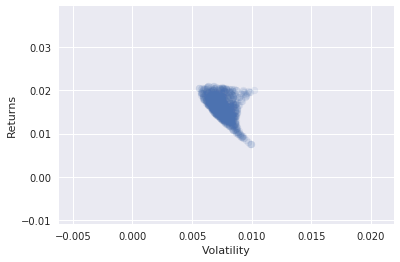

In [46]:
date = sorted(covariances.keys())[-1] #use latest date from the covariances dictionary

plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

<br>

### best portfolio
- lowest volatility? highest returns? best sharpe ratio? 
- $\mathrm{sharpe \, ratio} = \frac{\mathrm{portfolio \, return} - \mathrm{risk \, free \, return}}{\mathrm{portfolio \, standard \, deviation}}$

Create list of max sharpe indexes

In [47]:
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):    
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

efficient frontier with best Sharpe ratio

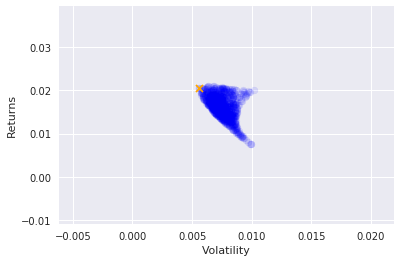

In [50]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

<br>

### Machine Learning for MPT
- targets: ideal portfolio weights
- features: exponentially weighted moving averages of prices
- RandomForestRegressor

Calculate exponentially-weighted moving average of daily returns (EWMA)

In [48]:
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with average for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG     0.000992
SPY     0.001504
MSFT    0.001836
Name: 2018-01-01 00:00:00, dtype: float64


make features and targets

In [49]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():
    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[9.16412366e-01 4.17184292e-02 4.18692046e-02]
 [4.07067907e-02 9.58324671e-01 9.68537945e-04]
 [4.47144398e-03 2.71414238e-02 9.68387132e-01]
 [2.87120268e-03 9.82480885e-01 1.46479127e-02]
 [6.02352813e-02 9.26481398e-01 1.32833206e-02]]


**create train and test then fit**

In [58]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets);

**Evaluate performance**

R^2 train: 0.837
R^2 test: -0.179


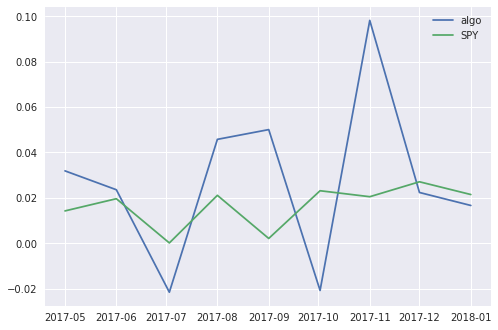

In [59]:
print(f"R^2 train: {rfr.score(train_features, train_targets):0.3f}")
print(f"R^2 test: {rfr.score(test_features, test_targets):0.3f}")


# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()

**Calculate return from hypothetical portfolio**

In [60]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.2682559919946291
SPY returns: 0.15920114173539718


Plot the algo_cash and spy_cash to compare returns between our predictions and the spy stock

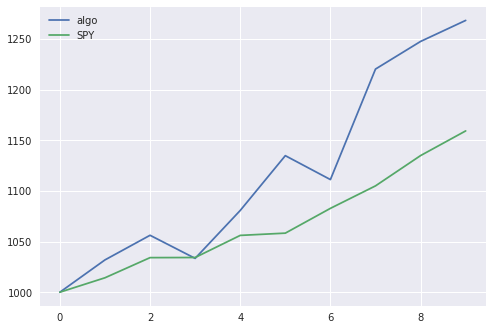

In [61]:
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()